### Summary


> 2. Written in tensorflow and executed using Keras Layers.

> 3. Tested on MNIST dataset. 

> 4. 95% test accuracy for 10 epochs.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from utils import check_balance,visulaize, creat_datasets

from callbacks import save_best_model_callback , tensorboard_callback, create_callback_list 
from callbacks import custombn_paper_callback, bn_keras_callbck, custom_BLNLayer_callback
from callbacks import comb_cBNpaper_cBLNLayer_callback, comb_cBNpaper_cBLNLayer_chMean_callback, ln_keras_callbck

from layers import dense_layer, custombn_paper, bn_keras, customBatchLayerNormalLayer, reset_graph
from layers import comb_cBNpaper_cBLNLayer, comb_cBNpaper_cBLNLayer_chMean

In [2]:
tf.config.experimental_run_functions_eagerly(True)

In [3]:
tf.__version__

'2.1.0'

### Loading data

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
#check_balance(y_train, y_test)

### Visualization

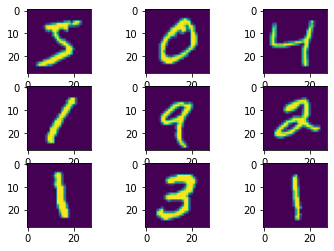

In [6]:
visulaize(x_train)

In [7]:
random_seed=100
minibatch = 60
buffersize= 60000
n_of_sampels = 5000
epochs=10

#### Creating tf.data.Datasets

In [8]:
train_dataset, valid_dataset, test_dataset = creat_datasets(x_train, y_train, x_test, y_test,
                                                            number_of_sampels = n_of_sampels,  random_seed=random_seed,
                                                            minibatch = minibatch,  buffersize= buffersize)

In [9]:
for i, j in valid_dataset.take(1) :
    print(i.shape, j.shape)

(60, 784) (60, 10)


# 1. Using Custom Batch and Layer Normalization Layer(cBLN)

In [10]:
def custom_BLNLayer_model(inputshape = [1], units1 = 100, units2 =100, units3=100,
                         classes=10, random_seed=100):
    
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=None, name = 'input')
    
    dense1 = dense_layer(units = units1, name = 'dense1', trainable = True, random_seed=random_seed)(input_lyr)
    custombn1 = customBatchLayerNormalLayer()(dense1)     
    activation1 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv1')(custombn1)
    
    dense2 = dense_layer(units = units2, name = 'dense2', trainable = True, random_seed=random_seed)(activation1)    
    custombn2 = customBatchLayerNormalLayer()(dense2)     
    activation2 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv2')(custombn2)
    
    dense3 = dense_layer(units = units3, name = 'dense3', trainable = True, random_seed=random_seed)(activation2)    
    custombn3 = customBatchLayerNormalLayer()(dense3)     
    activation3 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv3')(custombn3)
    
    
    output_lyr = dense_layer(units = classes, name='output', random_seed=random_seed) (activation3)
    # no softmax 
    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])

In [11]:
model_custom_bln_layer = custom_BLNLayer_model(inputshape=(784,), random_seed=random_seed)
model_custom_bln_layer.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense1 (dense_layer)         (None, 100)               78500     
_________________________________________________________________
custom_batch_layer_normal_la (None, 100)               602       
_________________________________________________________________
actv1 (Activation)           (None, 100)               0         
_________________________________________________________________
dense2 (dense_layer)         (None, 100)               10100     
_________________________________________________________________
custom_batch_layer_normal_la (None, 100)               602       
_________________________________________________________________
actv2 (Activation)           (None, 100)               0     

# callbacks

In [12]:
# Callbacks for saving best model and tensorboard
save_bm_cb = save_best_model_callback('custom_BLN_Layer')
tb_cb = tensorboard_callback('custom_BLN_Layer')

# Callback for resetting moving mean and variances at the end of each epoch
custom_bln_layer_cb = custom_BLNLayer_callback()

custom_bln_layer_cb_list = create_callback_list(save_bm_cb, tb_cb, custom_bln_layer_cb)

In [13]:
model_custom_bln_layer.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                               loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                               metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [14]:
model_custom_bln_layer_history =  model_custom_bln_layer.fit(train_dataset.take(100), epochs=epochs, verbose=1, 
                                           callbacks=custom_bln_layer_cb_list, validation_data=valid_dataset.take(50),
                                              shuffle=True)

Train for 100 steps, validate for 50 steps
0
Epoch 1/10
100/100 [==============================] - 5s 47ms/step - loss: 0.5952 - categorical_accuracy: 0.8307 - val_loss: 0.3535 - val_categorical_accuracy: 0.8973
1
Epoch 2/10
100/100 [==============================] - 4s 43ms/step - loss: 0.3224 - categorical_accuracy: 0.9057 - val_loss: 0.3125 - val_categorical_accuracy: 0.9103
2
Epoch 3/10
100/100 [==============================] - 4s 44ms/step - loss: 0.2809 - categorical_accuracy: 0.9193 - val_loss: 0.2600 - val_categorical_accuracy: 0.9207
3
Epoch 4/10
100/100 [==============================] - 4s 45ms/step - loss: 0.2348 - categorical_accuracy: 0.9318 - val_loss: 0.2397 - val_categorical_accuracy: 0.9307
4
Epoch 5/10
100/100 [==============================] - 4s 43ms/step - loss: 0.2223 - categorical_accuracy: 0.9337 - val_loss: 0.2284 - val_categorical_accuracy: 0.9303
5
Epoch 6/10
100/100 [==============================] - 4s 44ms/step - loss: 0.1910 - categorical_accuracy: 0.94

In [15]:
model_custom_bln_layer.evaluate(test_dataset)#[0.17817965790584503, 0.9497992]

166/166 [==============================] - 2s 13ms/step - loss: 0.1782 - categorical_accuracy: 0.9498


[0.17817965790584503, 0.9497992]

In [16]:
del model_custom_bln_layer, save_bm_cb, tb_cb, custom_bln_layer_cb, custom_bln_layer_cb_list
reset_graph()

session is clear


# 2. Using combination of cBNpaper and cBLN

# Model

In [17]:
def comb_cBNpaper_cBLNLayer_model(inputshape = [1], units1 = 100, units2 =100, units3=100,
                                  classes=10, random_seed=100):
    
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=None, name = 'input')
    
    dense1 = dense_layer(units = units1, name = 'dense1', trainable = True, random_seed=random_seed)(input_lyr)
    custombn1 = comb_cBNpaper_cBLNLayer(stateful = True, name = 'bn1', trainable = True)(dense1)   
    activation1 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv1')(custombn1)
    
    dense2 = dense_layer(units = units2, name = 'dense2', trainable = True, random_seed=random_seed)(activation1)    
    custombn2 = comb_cBNpaper_cBLNLayer(stateful = True, name = 'bn2', trainable = True)(dense2)     
    activation2 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv2')(custombn2)
    
    dense3 = dense_layer(units = units3, name = 'dense3', trainable = True, random_seed=random_seed)(activation2)    
    custombn3 = comb_cBNpaper_cBLNLayer(stateful = True, name='bn3', trainable = True)(dense3)     
    activation3 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv3')(custombn3)
    
    
    output_lyr = dense_layer(units = classes, name='output', random_seed=random_seed) (activation3)
    # no softmax 
    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])

In [18]:
model_comb_cbnpaper_cblnLayer = comb_cBNpaper_cBLNLayer_model(inputshape=(784,), random_seed=random_seed)
model_comb_cbnpaper_cblnLayer.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense1 (dense_layer)         (None, 100)               78500     
_________________________________________________________________
bn1 (comb_cBNpaper_cBLNLayer (None, 100)               603       
_________________________________________________________________
actv1 (Activation)           (None, 100)               0         
_________________________________________________________________
dense2 (dense_layer)         (None, 100)               10100     
_________________________________________________________________
bn2 (comb_cBNpaper_cBLNLayer (None, 100)               603       
_________________________________________________________________
actv2 (Activation)           (None, 100)               0     

In [19]:
model_comb_cbnpaper_cblnLayer.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                     metrics = [tf.keras.metrics.CategoricalAccuracy()])

# Callbacks

In [20]:

# Callbacks for saving best model and tensorboard
save_bm_cb = save_best_model_callback('comb_cBNpaper_cBLN')
tb_cb = tensorboard_callback('comb_cBNpaper_cBLN')

# Callback for resetting moving mean and variances at the end of each epoch
comb_cBNpaper_cBLNLayer_cb = comb_cBNpaper_cBLNLayer_callback(batchsize=minibatch)

comb_cBNpaper_cBLNLayer_cb_list = create_callback_list(save_bm_cb, tb_cb, comb_cBNpaper_cBLNLayer_cb)

In [21]:
model_comb_cbnpaper_cblnLayer_history =  model_comb_cbnpaper_cblnLayer.fit(train_dataset.take(100), epochs=epochs,
                                                                   verbose=1, callbacks=comb_cBNpaper_cBLNLayer_cb_list,
                                                                   validation_data=valid_dataset.take(50), shuffle=True)

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 4s 43ms/step - loss: 0.6620 - categorical_accuracy: 0.8037 - val_loss: 0.3923 - val_categorical_accuracy: 0.8777
Epoch 2/10
100/100 [==============================] - 4s 40ms/step - loss: 0.3254 - categorical_accuracy: 0.9037 - val_loss: 0.3136 - val_categorical_accuracy: 0.9113
Epoch 3/10
100/100 [==============================] - 4s 40ms/step - loss: 0.2591 - categorical_accuracy: 0.9217 - val_loss: 0.2813 - val_categorical_accuracy: 0.9200
Epoch 4/10
100/100 [==============================] - 4s 39ms/step - loss: 0.2435 - categorical_accuracy: 0.9260 - val_loss: 0.2578 - val_categorical_accuracy: 0.9303
Epoch 5/10
100/100 [==============================] - 4s 40ms/step - loss: 0.1979 - categorical_accuracy: 0.9402 - val_loss: 0.2268 - val_categorical_accuracy: 0.9380
Epoch 6/10
100/100 [==============================] - 4s 40ms/step - loss: 0.1885 - categorical_accuracy: 0.9470 - val_los

In [22]:
model_comb_cbnpaper_cblnLayer.evaluate(test_dataset)#[0.17397114536893296, 0.94728917]

166/166 [==============================] - 2s 10ms/step - loss: 0.1740 - categorical_accuracy: 0.9473


[0.17397114536893296, 0.94728917]

In [23]:
del model_comb_cbnpaper_cblnLayer, save_bm_cb, tb_cb,comb_cBNpaper_cBLNLayer_cb, comb_cBNpaper_cBLNLayer_cb_list
reset_graph()

session is clear


## 3. Using combination  of cBNpaper and cBLN plus channel Mean and Variance

In [24]:
def comb_cBNpaper_cBLNLayer_chMean_model(inputshape = [1], units1 = 100, units2 =100, units3=100,
                                  classes=10, batchsize=60, random_seed=100):
    
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=None, name = 'input')
    
    dense1 = dense_layer(units = units1, name = 'dense1', trainable = True, random_seed=random_seed)(input_lyr)
    custombn1 = comb_cBNpaper_cBLNLayer_chMean(stateful = True,batch_size= batchsize, name = 'bn1', trainable = True)(dense1)   
    activation1 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv1')(custombn1)
    
    dense2 = dense_layer(units = units2, name = 'dense2', trainable = True, random_seed=random_seed)(activation1)    
    custombn2 = comb_cBNpaper_cBLNLayer_chMean(stateful = True, batch_size= batchsize, name = 'bn2', trainable = True)(dense2)     
    activation2 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv2')(custombn2)
    
    dense3 = dense_layer(units = units3, name = 'dense3', trainable = True, random_seed=random_seed)(activation2)    
    custombn3 = comb_cBNpaper_cBLNLayer_chMean(stateful = True, batch_size= batchsize, name='bn3', trainable = True)(dense3)     
    activation3 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv3')(custombn3)
    
    
    output_lyr = dense_layer(units = classes, name='output', random_seed=random_seed) (activation3)
    # no softmax 
    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])

In [25]:
model_comb_cbnpaper_cblnLayer_chmean = comb_cBNpaper_cBLNLayer_chMean_model(inputshape=(784,), random_seed=random_seed,
                                                                  batchsize=minibatch)
model_comb_cbnpaper_cblnLayer_chmean.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense1 (dense_layer)         (None, 100)               78500     
_________________________________________________________________
bn1 (comb_cBNpaper_cBLNLayer (None, 100)               723       
_________________________________________________________________
actv1 (Activation)           (None, 100)               0         
_________________________________________________________________
dense2 (dense_layer)         (None, 100)               10100     
_________________________________________________________________
bn2 (comb_cBNpaper_cBLNLayer (None, 100)               723       
_________________________________________________________________
actv2 (Activation)           (None, 100)               0     

In [26]:
model_comb_cbnpaper_cblnLayer_chmean.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                                             loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                             metrics = [tf.keras.metrics.CategoricalAccuracy()])

# Callbacks

In [27]:
# Callbacks for saving best model and tensorboard
save_bm_cb = save_best_model_callback('comb_cBNpaper_cBLNLayer_chMean')
tb_cb = tensorboard_callback('comb_cBNpaper_cBLNLayer_chMean')

# Callback for resetting moving mean and variances at the end of each epoch
comb_cbnpaper_cblnLayer_chMean_cb = comb_cBNpaper_cBLNLayer_chMean_callback(batchsize=minibatch)

comb_cbnpaper_cblnLayer_chMean_cb_list = create_callback_list(save_bm_cb, tb_cb, comb_cbnpaper_cblnLayer_chMean_cb)

In [28]:
model_comb_cbnpaper_cblnLayer_chmean_history =  model_comb_cbnpaper_cblnLayer_chmean.fit(train_dataset.take(100), epochs=epochs,
                                                                                   verbose=1, callbacks=comb_cbnpaper_cblnLayer_chMean_cb_list,
                                                                                   validation_data=valid_dataset.take(50), shuffle=True)

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 4s 39ms/step - loss: 0.6672 - categorical_accuracy: 0.8045 - val_loss: 0.3818 - val_categorical_accuracy: 0.8923
Epoch 2/10
100/100 [==============================] - 4s 40ms/step - loss: 0.3295 - categorical_accuracy: 0.9043 - val_loss: 0.3000 - val_categorical_accuracy: 0.9157
Epoch 3/10
100/100 [==============================] - 4s 39ms/step - loss: 0.2655 - categorical_accuracy: 0.9242 - val_loss: 0.2709 - val_categorical_accuracy: 0.9183
Epoch 4/10
100/100 [==============================] - 4s 39ms/step - loss: 0.2465 - categorical_accuracy: 0.9283 - val_loss: 0.2410 - val_categorical_accuracy: 0.9290
Epoch 5/10
100/100 [==============================] - 4s 39ms/step - loss: 0.2012 - categorical_accuracy: 0.9443 - val_loss: 0.2211 - val_categorical_accuracy: 0.9377
Epoch 6/10
100/100 [==============================] - 4s 39ms/step - loss: 0.1991 - categorical_accuracy: 0.9405 - val_los

In [29]:
model_comb_cbnpaper_cblnLayer_chmean.evaluate(test_dataset)#[0.17009353063192711, 0.9501004]

166/166 [==============================] - 2s 9ms/step - loss: 0.1701 - categorical_accuracy: 0.9501


[0.17009353063192711, 0.9501004]

In [30]:
del model_comb_cbnpaper_cblnLayer_chmean, save_bm_cb, tb_cb, comb_cbnpaper_cblnLayer_chMean_cb, comb_cbnpaper_cblnLayer_chMean_cb_list
reset_graph()

session is clear


# 4. Using the custom Batch Normalization paper (cBNpaper)


In [31]:
# 3 dense layers followed by 3 batch norm layers and a final dense layer with units equal to number of categories
def custom_bnpaper_model(inputshape = [1], units1 = 100, units2 =100, units3=100, classes=10, random_seed=100):
    
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=None, name = 'input')
    
    dense1 = dense_layer(units = units1, name = 'dense1', trainable = True, random_seed=random_seed)(input_lyr)
    custombn1 = custombn_paper(stateful = True, name = 'bn1', trainable = True)(dense1)     
    activation1 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv1')(custombn1)
    
    dense2 = dense_layer(units = units2, name = 'dense2', trainable = True, random_seed=random_seed)(activation1)    
    custombn2 = custombn_paper(stateful = True, name = 'bn2', trainable = True)(dense2)     
    activation2 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv2')(custombn2)
    
    dense3 = dense_layer(units = units3, name = 'dense3', trainable = True, random_seed=random_seed)(activation2)    
    custombn3 = custombn_paper(stateful = True, name='bn3', trainable = True)(dense3)     
    activation3 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv3')(custombn3)
    
    
    output_lyr = dense_layer(units = classes, name='output', random_seed=random_seed) (activation3)
    # no softmax 
    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])

In [32]:
# Callbacks for saving best model and tensorboard
save_bm_cb = save_best_model_callback('custombn_paper')
tb_cb = tensorboard_callback('custombn_paper')

# Callback for resetting moving mean and variances at the end of each epoch
custom_bn_paper_cb = custombn_paper_callback(batchsize=minibatch)
### Custom Callbacks
cstm_bn_paper_cb_list = create_callback_list(save_bm_cb, tb_cb, custom_bn_paper_cb)

reset_graph()


session is clear


In [33]:
model_custom_bnpaper = custom_bnpaper_model(inputshape=(784,), random_seed=random_seed)
model_custom_bnpaper.summary()

# Adam optimizer has adaptive learning rate feature
model_custom_bnpaper.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),\
                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics = [tf.keras.metrics.CategoricalAccuracy()])
# If using softmax as the activation of the last layer, then from_logits should be False

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense1 (dense_layer)         (None, 100)               78500     
_________________________________________________________________
bn1 (custombn_paper)         (None, 100)               403       
_________________________________________________________________
actv1 (Activation)           (None, 100)               0         
_________________________________________________________________
dense2 (dense_layer)         (None, 100)               10100     
_________________________________________________________________
bn2 (custombn_paper)         (None, 100)               403       
_________________________________________________________________
actv2 (Activation)           (None, 100)               0     

In [34]:
model_custom_bnpaper_history =  model_custom_bnpaper.fit(train_dataset.take(100), epochs=epochs, verbose=1, 
                                                   callbacks=cstm_bn_paper_cb_list,
                                                   validation_data=valid_dataset.take(50),
                                                   shuffle=True)

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 3s 26ms/step - loss: 0.6225 - categorical_accuracy: 0.8187 - val_loss: 0.3569 - val_categorical_accuracy: 0.8980
Epoch 2/10
100/100 [==============================] - 3s 26ms/step - loss: 0.3480 - categorical_accuracy: 0.8967 - val_loss: 0.3032 - val_categorical_accuracy: 0.9183
Epoch 3/10
100/100 [==============================] - 3s 26ms/step - loss: 0.3064 - categorical_accuracy: 0.9108 - val_loss: 0.2805 - val_categorical_accuracy: 0.9210
Epoch 4/10
100/100 [==============================] - 3s 26ms/step - loss: 0.2742 - categorical_accuracy: 0.9205 - val_loss: 0.2503 - val_categorical_accuracy: 0.9303
Epoch 5/10
100/100 [==============================] - 3s 26ms/step - loss: 0.2409 - categorical_accuracy: 0.9265 - val_loss: 0.2402 - val_categorical_accuracy: 0.9293
Epoch 6/10
100/100 [==============================] - 3s 27ms/step - loss: 0.2207 - categorical_accuracy: 0.9318 - val_los

In [35]:
# test dataset
model_custom_bnpaper.evaluate(test_dataset)#[0.18420373356665473, 0.94668674]

166/166 [==============================] - 1s 8ms/step - loss: 0.1842 - categorical_accuracy: 0.9467


[0.18420373356665473, 0.94668674]

In [36]:
del model_custom_bnpaper, save_bm_cb, tb_cb, cstm_bn_paper_cb_list
reset_graph()

session is clear


# 5.Using the Batch Normal layer implemented in tensorflow

In [37]:
def bn_keras_model(inputshape = [1], units1 = 100, units2 =100, units3=100, classes=10, random_seed=100):
    
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=None, name = 'input')
    
    dense1 = dense_layer(units = units1, name = 'dense1', trainable = True, random_seed=random_seed)(input_lyr)
    custombn1 = bn_keras(momentum = 0.99, stateful = True, name = 'bn1', trainable = True)(dense1)     
    activation1 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv1')(custombn1)
    
    dense2 = dense_layer(units = units2, name = 'dense2', trainable = True, random_seed=random_seed)(activation1)    
    custombn2 = bn_keras(momentum = 0.99, stateful = True, name = 'bn2', trainable = True)(dense2)     
    activation2 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv2')(custombn2)
    
    dense3 = dense_layer(units = units3, name = 'dense3', trainable = True, random_seed=random_seed)(activation2)    
    custombn3 = bn_keras(momentum = 0.99, stateful = True, name='bn3', trainable = True)(dense3)     
    activation3 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv3')(custombn3)
    
    
    output_lyr = dense_layer(units = classes, name='output', random_seed=random_seed) (activation3)
    # no softmax 
    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])

In [38]:
model_bn_keras = bn_keras_model(inputshape=(784,), random_seed=random_seed)
model_bn_keras.summary()

#### Compiling 
model_bn_keras.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics = [tf.keras.metrics.CategoricalAccuracy()])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense1 (dense_layer)         (None, 100)               78500     
_________________________________________________________________
bn1 (bn_keras)               (None, 100)               401       
_________________________________________________________________
actv1 (Activation)           (None, 100)               0         
_________________________________________________________________
dense2 (dense_layer)         (None, 100)               10100     
_________________________________________________________________
bn2 (bn_keras)               (None, 100)               401       
_________________________________________________________________
actv2 (Activation)           (None, 100)               0     

In [39]:
# Callbacks for saving best model and tensorboard
save_bm_cb = save_best_model_callback('bn_Keras')
tb_cb = tensorboard_callback('bn_Keras')

# Callback for resetting moving mean and variances at the end of each epoch
bn_keras_cb = bn_keras_callbck()

bn_keras_cb_list = create_callback_list(save_bm_cb, tb_cb, bn_keras_cb)

In [40]:
model_bn_keras_history =  model_bn_keras.fit(train_dataset.take(100), epochs=epochs, verbose=1, 
                                    callbacks=bn_keras_cb_list, validation_data=valid_dataset.take(50),
                                    shuffle=True)

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 3s 30ms/step - loss: 0.6253 - categorical_accuracy: 0.8213 - val_loss: 0.3781 - val_categorical_accuracy: 0.8977
Epoch 2/10
100/100 [==============================] - 3s 29ms/step - loss: 0.3538 - categorical_accuracy: 0.8968 - val_loss: 0.3415 - val_categorical_accuracy: 0.9003
Epoch 3/10
100/100 [==============================] - 3s 29ms/step - loss: 0.2966 - categorical_accuracy: 0.9092 - val_loss: 0.2910 - val_categorical_accuracy: 0.9210
Epoch 4/10
100/100 [==============================] - 3s 30ms/step - loss: 0.2648 - categorical_accuracy: 0.9220 - val_loss: 0.2879 - val_categorical_accuracy: 0.9173
Epoch 5/10
100/100 [==============================] - 3s 29ms/step - loss: 0.2593 - categorical_accuracy: 0.9198 - val_loss: 0.2616 - val_categorical_accuracy: 0.9227
Epoch 6/10
100/100 [==============================] - 3s 30ms/step - loss: 0.2300 - categorical_accuracy: 0.9312 - val_los

In [41]:
model_bn_keras.evaluate(test_dataset)#[0.20873597329370228, 0.9370482]

166/166 [==============================] - 1s 7ms/step - loss: 0.2087 - categorical_accuracy: 0.9370


[0.20873597329370228, 0.9370482]

In [42]:
del model_bn_keras, save_bm_cb, tb_cb, bn_keras_cb_list 
reset_graph()

session is clear


# 6.Using The Layer normalization layer  implemented in tensorflow

In [43]:
def ln_keras_model(inputshape = [1], units1 = 100, units2 =100, units3=100, classes=10, random_seed=100):
    
    input_lyr = tf.keras.Input(shape = inputshape, batch_size=None, name = 'input')
    
    dense1 = dense_layer(units = units1, name = 'dense1', trainable = True, random_seed=random_seed)(input_lyr)
    custombn1 =  tf.keras.layers.LayerNormalization()(dense1)     
    activation1 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv1')(custombn1)
    
    dense2 = dense_layer(units = units2, name = 'dense2', trainable = True, random_seed=random_seed)(activation1)    
    custombn2 =  tf.keras.layers.LayerNormalization()(dense2)     
    activation2 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv2')(custombn2)
    
    dense3 = dense_layer(units = units3, name = 'dense3', trainable = True, random_seed=random_seed)(activation2)    
    custombn3 = tf.keras.layers.LayerNormalization()(dense3)     
    activation3 = tf.keras.layers.Activation(activation = tf.nn.tanh, name='actv3')(custombn3)
    
    
    output_lyr = dense_layer(units = classes, name='output', random_seed=random_seed) (activation3)
    # no softmax 
    
    return tf.keras.Model(inputs = [input_lyr], outputs = [output_lyr])

In [44]:
model_ln_keras = ln_keras_model(inputshape=(784,), random_seed=random_seed)
model_ln_keras.summary()

#### Compiling 
model_ln_keras.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics = [tf.keras.metrics.CategoricalAccuracy()])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense1 (dense_layer)         (None, 100)               78500     
_________________________________________________________________
layer_normalization (LayerNo (None, 100)               200       
_________________________________________________________________
actv1 (Activation)           (None, 100)               0         
_________________________________________________________________
dense2 (dense_layer)         (None, 100)               10100     
_________________________________________________________________
layer_normalization_1 (Layer (None, 100)               200       
_________________________________________________________________
actv2 (Activation)           (None, 100)               0     

In [45]:
# Callbacks for saving best model and tensorboard
save_bm_cb = save_best_model_callback('ln_Keras')
tb_cb = tensorboard_callback('ln_Keras')

# Callback for resetting moving mean and variances at the end of each epoch
ln_keras_cb = ln_keras_callbck()

ln_keras_cb_list = create_callback_list(save_bm_cb, tb_cb, ln_keras_cb)

In [ ]:
model_ln_keras_history =  model_ln_keras.fit(train_dataset.take(100), epochs=epochs, verbose=1, 
                                    callbacks=ln_keras_cb_list, validation_data=valid_dataset.take(50),
                                    shuffle=True)

Train for 100 steps, validate for 50 steps
0
Epoch 1/10
 36/100 [=========>....................] - ETA: 3s - loss: 0.9132 - categorical_accuracy: 0.7227

In [ ]:
model_ln_keras.evaluate(test_dataset)#[0.18083889394190655, 0.9469879]

In [ ]:
del model_ln_keras,save_bm_cb, ln_keras_cb, ln_keras_cb_list
reset_graph()